In [1]:
import allel
import malariagen_data
import pandas as pd
import numpy as np
%matplotlib inline
import probe
%run hapclust.py
import json
import locusPocus
import statsmodels.api as sm

### Hap association tests - coeae1f

In [2]:
cohorts = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]


In [3]:
contig= '2L'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28540000-28560000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

In [5]:
name = 'coeae1f'

In [6]:
with open(f'../../results/{name}_locus_cluster_indices.json', 'r') as f:
    clust_inds = json.load(f)

In [7]:
haps = ag3.haplotypes(region=coeregion, sample_sets=cohorts, analysis='gamb_colu_arab')
names = haps['sample_id'].compute().values
metahaps, q = locusPocus.load_metahaps(cohorts, names, metaquery=None)
phenos = pd.read_csv("/home/sanj/projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)[['sample_id', 'partner_sample_id', 'insecticide', 'phenotype']]

Load sample metadata:   0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
def gaard_cluster_to_df(sample_sets, contig, name, load=f'../../results/{name}_locus_cluster_indices.json', cut=1, min_cluster_size=70, transcript=None):
    if not load:
        snpdf_227, clust_inds, leav = phase3cluster(cohorts, transcript, contig, cut=cut, t=0, min_cohort_size=min_cluster_size)
    else:
        with open(load, 'r') as f:
            clust_inds = json.load(f)
    
    metadata = pd.read_csv("/home/sanj/projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)
    haps = ag3.haplotypes(region=coeregion, sample_sets=sample_sets, analysis='gamb_colu_arab')
    names = haps['sample_id'].compute().values
    metahaps, q = locusPocus.load_metahaps(cohorts, names, metaquery=None)
    
    for k,v in clust_inds.items():
                
        k = name + "_" + k
        vals = np.zeros(metahaps.shape[0]).astype(int)
        vals[v] = 1
        metahaps.loc[:, k] = vals
        
    phenos = pd.read_csv("/home/sanj/projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)[['sample_id', 'partner_sample_id', 'insecticide', 'phenotype']]
    metahaps = pd.merge(phenos, metahaps, how='left')
    
    df = metahaps.copy()
    df = df[['sample_id', 'country', 'location', 'phenotype', 'insecticide']]
    df = df.groupby(['sample_id', 'country', 'location', 'phenotype', 'insecticide']).agg('sum').reset_index()
    return(df, metahaps)

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "odds_ratio":np.exp(coeff),
                               "conf_lower":np.exp(conf_lower),
                               "conf_higher":np.exp(conf_higher)
                                })
    
    results_df.loc[:, 'sig'] = ['significant' if pval <= 0.05 else 'not significant' for pval in pvals]

    #Reordering...
    results_df = results_df[["odds_ratio","pvals","conf_lower","conf_higher", "sig"]]
    return results_df

In [9]:
clusters_227, metahaps = gaard_cluster_to_df(cohorts, contig="2L", name='coeae1f')

In [10]:
glm_dict = {}
n_list = {}

for ins in ['PM', 'Delta']:
    df2 = metahaps.query("insecticide == @ins")   
    clusters = df2.iloc[:, 29:].astype(float)
    n_list[ins] = clusters.sum(axis=0)
    phenos = pd.factorize(df2['phenotype'])[0]
    
    # Instantiate a gamma family model with the default link function.
    logit_model = sm.GLM(phenos, clusters, family=sm.families.Binomial())
    logit_results = logit_model.fit()

    print(ins, logit_results.summary())
    print(np.exp(logit_results.params),"\n")
    params = logit_results.params
    conf = logit_results.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    print(np.exp(conf), "\n")
    
    glm_dict[ins] = results_summary_to_dataframe(logit_results)

PM                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  844
Model:                            GLM   Df Residuals:                      838
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -571.47
Date:                Sun, 18 Sep 2022   Deviance:                       1142.9
Time:                        16:47:16   Pearson chi2:                     844.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01433
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
coeae1f_C1    -1.0986      0.577     -1.903      

In [11]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

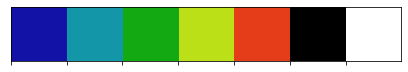

In [40]:
hap_labels = clust_inds.keys()

palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels)-2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((1, 1, 1))
# check
sns.palplot(palette)

In [41]:
del(palette[1])
palette

[(0.07255235294117646, 0.07255235294117646, 0.6529711764705882),
 (0.07385313725490195, 0.6646782352941176, 0.07385313725490195),
 (0.7377500000000003, 0.87999, 0.09777666666666662),
 (0.9, 0.24117647058823533, 0.09999999999999998),
 (0, 0, 0),
 (1, 1, 1)]

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


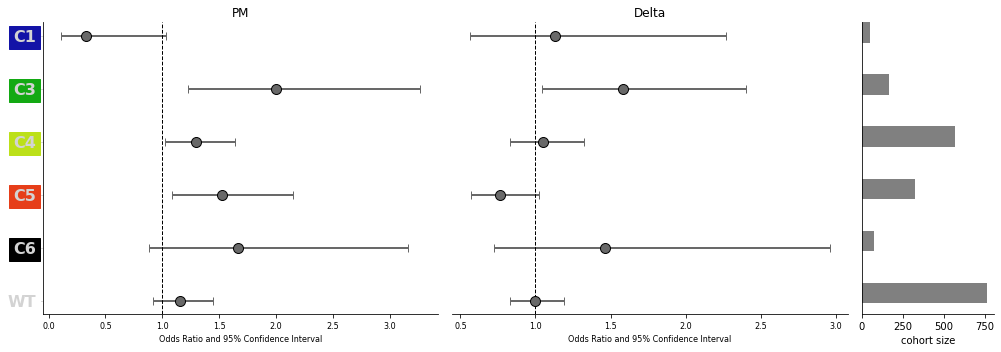

In [54]:
fig, ax = plt.subplots(1,3,figsize=(14, 5), gridspec_kw={'width_ratios':[3,3,1]})

n_df = pd.DataFrame(n_list)

for idx, ins in enumerate(['PM', 'Delta']):
    df = glm_dict[ins].reset_index().rename(columns={'index':'cluster'})
    df = df.query("cluster != 'coeae1f_C2'").reset_index(drop=True)
    df['conf_lower2'] = df['odds_ratio'] - df['conf_lower']
    df['conf_higher2'] =  df['conf_higher'] - df['odds_ratio']

    ax[idx].errorbar(x=df.iloc[::-1]['odds_ratio'], y=df.iloc[::-1]['cluster'], xerr=(df.iloc[::-1]['conf_lower2'].to_list(), df.iloc[::-1]['conf_higher2'].to_list()),
                color='dimgrey',  linewidth=2, capsize=4, linestyle='None',
                marker="o", markersize=10, mfc="dimgrey", mec="black")
    ax[idx].axvline(x=1, linewidth=1, linestyle='--', color='black')
    ax[idx].tick_params(axis='both', which='major', labelsize=8)
    ax[idx].set_title(ins)
    ax[idx].set_xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
    sns.despine(ax=ax[idx])
    #ax[idx].tight_layout()
    # plt.savefig('raw_forest_plot.png')
    
labels = np.array(list(clust_inds.keys()))
labels = labels[labels != 'C2']
ax[0].set_yticklabels(labels[::-1], fontsize=16, fontweight='bold')
for i, label in enumerate(labels):
    plt.setp(ax[0].get_yticklabels()[i], backgroundcolor=palette[::-1][i])
ax[0].yaxis.label.set_color('grey')
ax[0].tick_params(axis='y', colors='lightgrey')


ax[1].set_yticks([])
sns.despine(ax=ax[1], left=True)

n_df = n_df.reset_index().rename(columns={'index':'cohort name'})
n_df = n_df.query("`cohort name` != 'coeae1f_C2'")
n_df.loc[:, 'cohort size'] = n_df.sum(axis=1)
n_df['id'] = np.arange(0, n_df.shape[0])
sns.barplot(x='cohort size', y='cohort name', data=n_df.iloc[::-1], color='grey', ax=ax[2])
sns.despine(ax=ax[2])
ax[2].set_yticks([])
ax[2].set_ylabel("")
ax[2].set_ylim(-0.6, 5)
change_width(ax[2], 0.4)

plt.tight_layout()

fig.show()
fig.savefig("../../results/hap_association_test.png", dpi=150)

## which is which sweep

In [19]:
metahaps, q = locusPocus.load_metahaps(cohorts, names, metaquery=None)

df_list ={}
for k, v in clust_inds.items():
    
    metah = metahaps.take(v)
    
    pivot_country_year_taxon = (
    metah
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0))

    df_list[k] = pivot_country_year_taxon

In [24]:
df_list['C1'].sum().sum()

103

In [26]:
for k,v in df_list.items():
    print(k, v)
    
    print(v.sum().sum())
    print("\n")

C1 taxon                                            coluzzii  gambiae  \
sample_set                    year country                           
1237-VO-BJ-DJOGBENOU-VMF00050 2017 Benin               19        0   
1244-VO-GH-YAWSON-VMF00051    2018 Ghana               27        0   
1244-VO-GH-YAWSON-VMF00149    2018 Ghana               38        0   
AG1000G-BF-A                  2012 Burkina Faso         2        0   
AG1000G-BF-B                  2014 Burkina Faso         1        1   
AG1000G-GH                    2012 Ghana               12        0   
AG1000G-ML-A                  2014 Mali                 1        0   

taxon                                            intermediate_gambiae_coluzzii  
sample_set                    year country                                      
1237-VO-BJ-DJOGBENOU-VMF00050 2017 Benin                                     0  
1244-VO-GH-YAWSON-VMF00051    2018 Ghana                                     2  
1244-VO-GH-YAWSON-VMF00149    2018 Ghana  

In [ ]:
df_list['C1']

In [28]:
pd.read_csv("../../clusters.csv").fillna("")

,Cluster,cohort size,species,CNV
0,C1,103,An. coluzzii,
1,C2,89,An. arabiensis,Dup2
2,C3,462,An. gambiae,
3,C4,793,An. gambiae,
4,C5,529,An. coluzzii / gambiae,
5,C6,83,An. gambiae,Dup1
6,WT,2803,All,
